# Ray Tracing
Now that we are used to many of the tools and techniques to visualise objects, rotate and transform them, we can explore how mathematics allows us to check if/how some types of objects *interact* using Python: Ray Tracing.

In [1]:
## Libraries
%matplotlib inline
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D, proj3d

First we need to set up a ray and an object: after this we will explore if/how to equate the expressions for a specific value or values of the length along the ray. We will begin, as we did in the lectures, using spheres (or their 2D equivalent, circles) to illustrate the procedure.

Before we examine some specific examples, it would be nice to also visualise the examples as we go. We will therefore first set up some of the 3D objects that we will need to plot. First, we will want to visualise a 3D sphere. Lets set up a 3D object in the shape of a sphere:

In [2]:
def plt_sphere(center, radius):
  """ function to create and plot a 3D sphere at a given centre and radius
  """
  plt.subplot(projection='3d')
  # draw sphere
  u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
  x = radius*np.cos(u)*np.sin(v)+center[0]
  y = radius*np.sin(u)*np.sin(v)+center[1]
  z = radius*np.cos(v)+center[2]

  ax.plot_surface(x, y, z, color=np.random.choice(['g','b']), alpha=0.25)

This will just be used for plotting - we will create and use equations of spheres in this workbook, but this is just to save some lines when it comes to visulisation. 

We will also need to work with vectors, so lets create and use a custom arrow to represent each ray:

In [3]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

Again, don't worry about the details of this: this is just a couple of shortcuts to help speed things up later when we ask Python to draw some arrows.

## Background

In the lectures we saw that rays are often called "directed line segment vectors": they represent a beam of light starting at a particular position (the "origin" of the ray), and travelling in some 3D vector direction in space. The distance travelled along the vector is controlled by a parameter, often labelled "$t$"; just like we saw with curves several lectures ago, this parameter allows us to recover every single position which lies along the path of the ray.

### Rays expressed mathematically

There are several different ways to mathematically express this information. One common way is to express the origin and vector direction of the ray as column vectors (where the origin is converted into a vector by describing the distance from $(0,0,0)$ to the ray starting position). This looks like:

$$
\begin{align}
    {\mathbf{\vec{r}}} &=
          \begin{pmatrix}
           x_o \\           
           y_o \\
           z_o
          \end{pmatrix} +t
          \begin{pmatrix}
           v_x \\
           v_y \\
           v_z
         \end{pmatrix}.
  \end{align}
$$

The above expression describes a ray which starts at the point $(x_o, y_o, z_o)$, and travels parallel to the vector $\vec{\bf{v}}=v_x{\vec{\bf{i}}}+v_y{\vec{\bf{j}}}+v_z{\vec{\bf{k}}}$. 

The parameter $t$ must always greater than or equal to zero. If $t=0$, this expression recovers the start point of the ray i.e. $\vec{\bf{r}}=(x_o,y_o,z_o)$. If the ray has an end point, then we define $t$ to be constrained to lie in between $0$ and $1$, so that when $t=1$ the end point of the ray is recovered. Cases where the ray has an end point can sometimes be referred to as rays of "finite length". If the ray has no defined end point, then they may be referred to as rays of "infinite length", as there is nothing to stop the ray travelling off to infinity and beyond(!).

One may construct the ray equation for a finite length ray as follows:

$$
\begin{align}
    {\mathbf{\vec{r}}} &=
          \begin{pmatrix}
           x_o \\           
           y_o \\
           z_o
          \end{pmatrix} +t
          \begin{pmatrix}
           x_e - x_o \\
           y_e - y_o \\
           z_e - z_o
         \end{pmatrix},~~~ t\in\left[0,1\right].
  \end{align}
$$

This describes a ray which starts at $(x_o,y_o,z_o)$ and ends at $(x_e,y_e,z_e)$. Subtracting the start point from the end point forms a vector direction which the ray must travel along. Note also that substituting $t=1$ into this expression means that $\vec{\bf{r}}=(x_e,y_e,z_e)$, as it must.

In this workbook, we will take advantage of Python's ability to let us set up parameters, with constraints using the ``sym`` library. In this case, we'll create the parameter ``t`` as a symbol which is unknown at present but must be positive. Later, when we use specific examples, we can have Python solve for specific values of this parameter, as we do by hand.

In [4]:
t = sym.Symbol('t', positive=True)
x, y, z = sym.Symbol('x'), sym.Symbol('y'), sym.Symbol('z') 

(while we're at it, lets define our Cartesian coordinates $x, y, z$, which we'll need later)

### Intersections with objects

Key idea: To test if a ray intersects an object, one must **equate the ray equation with the equation describing (all/part of) the object**.

It's that simple.

This is easy to carry out for some simple mathematical objects which are entirely described by one equation. Objects like spheres are relatively common, and are perhaps the simplest type of object.

We've also encountered ways in previous lectures to describe other types of object (cylinders, cones, parabolic bowls, toruses, etc.) using parameterisation to map out their entire surface. Even the dreaded bilinear surface patches (yes, even those!).

We will see shortly that we can construct more complicated objects by combining simple mathematical surfaces together; the downside with this approach is that we have to then check every part of the object with the ray. If the object comprises thousands/millions of surfaces, then it can be more efficient to utilise a **bounding box** like a sphere to avoid unecessary, computationally intense intersection calculations.

If the surface we are comparing is also parameterised, then we have to set up a set of **simultaneous equations** when we check for intersections. This is because we will have *two* (or sometimes even three) unknown parameters. We need at least as many equations as unknowns to solve this type of problem.

We won't worry about this for now, and look at intersections between rays and spheres.

### Normals

We've also taken care in previous lectures to calculate surface normals.

For parameterised surfaces, we have seen that partial differentiation can produce tangent vectors, and that the cross product of these tangent vectors can produce a normal.

If the surface is not parameterised, for example in the case of a sphere, then we can use the gradient function, $\vec{\nabla}{\phi}$ to calculate the normal. In the lectures I showed a formula to calculate the unit normal to a sphere: this formula comes directly from the gradient function, $\vec{\nabla}{\phi}$.

The operator $\vec{\nabla}$ is quite common in a wide range of areas of physics, maths and engineering. It evaluates the derivative of the scalar function fed to it, and pipes out the derivative in each Cartesian direction as part of a vector:

$$
\vec{\bf{\nabla}}{\phi}=\left[\frac{\partial \phi}{\partial x}{\vec{\bf{i}}}+\frac{\partial \phi}{\partial y}{\vec{\bf{j}}}+\frac{\partial \phi}{\partial z}{\vec{\bf{k}}}\right]
$$

A quick example; evaluate $\vec{\nabla}{F}$ for $F(x,y,z)= x+y^2+z^3$:

$$
\vec{\bf{\nabla}}{F(x,y,z)} = \left[\frac{\partial F}{\partial x}{\vec{\bf{i}}}+\frac{\partial F}{\partial y}{\vec{\bf{j}}}+\frac{\partial F}{\partial z}{\vec{\bf{k}}}\right] =
1{\vec{\bf{i}}}+2y{\vec{\bf{j}}}+3z^2{\vec{\bf{k}}}
$$

We must also remember that the normal can vary over the surface, and is a function of position, so one must evaluate the surface normal at *specific coordinates*, for example those found when calculating an intersection point.

For later use, I will create a subroutine that returns the gradient of a given scalar function $\phi(x,y,z)$, and take advantage of ``sympy`` which has the ability to differentiate expressions using ``sympy.diff``.


In [5]:
def grad(phi):
    gradphi = [sym.diff(phi,x), sym.diff(phi,y), sym.diff(phi,z)]
    return gradphi

Lets now see how this knowledge is put into practise in Python. We'll tackle a few of the examples shown in the lectures, both to verify the mathematics we carried out by hand, and also to visualise the results of the calculation using 3D Python plotting commands.

We'll begin with Example 1 from the lectures, which saw a ray miss a sphere.

## Lecture Example 1: Does a ray intersect a sphere?
**Determine if the ray from $(-1,0,3)$ with direction $2\vec{i}-3\vec{j}+\vec{k}$ intersects a sphere with centre $(3,3,3)$ and radius $2$.**

First we will set up the ray, combining an origin and the direction stated in the question. The ray is of infinite extent. We can therefore create two vectors in Python, and add them to form the ray equation, scaling the vector direction by the parameter we defined earlier, ``t``:

In [6]:
ray_o = sym.Matrix([[-1, 0, 3]])
ray_v = sym.Matrix([[2, 3, 1]])
ray = ray_o + t * ray_v

(note that we have defined these vectors using a ``sym.Matrix`` construct. There are many ways to store and organise arrays in Python, including lists, arrays, vectors, matrices to name but a few. I found this datatype easiest to work with, but I highly doubt this is the most efficient way to do this; if you know better ways to tackle the problem, go for it!)

We want to explore if this ray interacts with the sphere given in the question. The equation of a sphere is, as we know, 

$$(x-a)^2+(y-b)^2+(z-c)^2 = r^2, 
$$

for a sphere centred on $(a,b,c)$ with radius $r$. 

We can replicate this in Python, again using symbols for variables $x$, $y$ and $z$. To confirm we have the correct expression, we'll create it and print it:

In [7]:
sphere_c = sym.Matrix([[3, 3, 3]])
sphere_r = 2
sphere = (x - sphere_c[0])**2+(y - sphere_c[1])**2+(z - sphere_c[2])**2-sphere_r**2
print(sphere)

(x - 3)**2 + (y - 3)**2 + (z - 3)**2 - 4


Note that Python likes to work with equations where all the quantities occur on one side of the equals sign, which means everything $=0$. The expression ``sphere`` looks like ``(x-3)**2+(y-3)**2+(z-3)**2-4`` because that must now equal zero.

**key step incoming!**

In the lectures, we saw that we need to substitute the parametric form of the ray equation into the equation of the sphere, then solve for the value of parameter $t$ by hand. We can do this in **one line** in Python:

In [8]:
print(sym.solve(sphere.subs([(x, ray[0]), (y, ray[1]), (z, ray[2])]),t))

[]


The result is not a mistake; it is Python's way of saying that it could not find any solutions.

We placed a restriction on the parameter t that it must be positive: this tells Python that t cannot be imaginary. If we remove the positive restriction on t, we can determine the complex solutions to this equation. However, complex values means that there are *no* intersections between this sphere and this ray.


---


We should check this result visually with a plot.

So far, we have saved coordinates as a `sym.Matrix`, which has allowed us to create 3D vectors for our ray. Sadly, a lot of the plotting routines work with a different data structure, so we'll have to convert important coordinates to the correct datatype in order to plot them:

In [9]:
ro = np.array(ray_o.tolist()[0],dtype='float64') #convert ray origin to numpy array
spc = np.array(sphere_c.tolist()[0],dtype='float64') #convert sphere centre to numpy array

Finally, we can plot the sphere in the required location, the directed line segment (ray) and check visually if the objects appear to intersect:

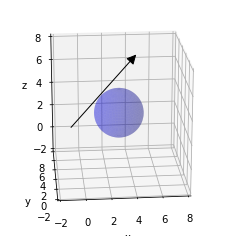

In [10]:
ax = plt.figure().add_subplot(projection='3d')
ax.view_init(elev=20, azim=265, roll=0)
ax.axes.set_xlim3d(left=-2, right=8) 
ax.axes.set_ylim3d(bottom=-2, top=8) 
ax.axes.set_zlim3d(bottom=-2, top=8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt_sphere(spc,sphere_r)
end = (ray.subs(t,3))
end=np.array(end.tolist()[0],dtype='float64')
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0, linewidth=1)
b = Arrow3D([ro[0], end[0]], [ro[1], end[1]], [ro[2], end[2]], **arrow_prop_dict)
ax.add_artist(b)
plt.gca().set_aspect('equal')
plt.show() 

In this example, it is clear that the ray misses the sphere, as expected.

## Lecture Example 2: Multiple intersections and normal calculation
**Determine the unit normal where the ray from $(1,-2,-1)$ with direction ${\vec{i}}+2{\vec{j}}+4{\vec{k}}$ first intersects the sphere with centre $(3,0,5)$ and radius $3$.**

We will leave the unit normal calculation until after we have identified all intersections with the object. We'll recycle the same process we used in Example 1, but changing the constants to match the Example 2 values:

In [11]:
r2_o = sym.Matrix([[1, -2, -1]])
r2_v = sym.Matrix([[1, 2, 4]]) 
ray2 = r2_o + t * r2_v
s2_c = sym.Matrix([[3, 0, 5]])
s2_r = 3
s2 = (x - s2_c[0])**2+(y - s2_c[1])**2+(z - s2_c[2])**2-s2_r**2

We will again use the solve command to allow Python to find values of t when we substitute the parametric forms of the ray equation into the equation of the sphere.

Unlike last time, the solution we saw in class implies that we should expect two intersections. The first intersection corresponds to entering the sphere, and the second is when the ray leaves the sphere. We therefore need to arrange the solutions in size order, which the Python `sort` function will take care of. We can then print them in order:

In [12]:
sols = sym.solve(s2.subs([(x, ray2[0]), (y, ray2[1]), (z, ray2[2])]),t)
sols.sort()
for i, val in enumerate(sols):
    print("intersection {} found at t={}".format(i+1,val.evalf()))

intersection 1 found at t=0.816893686730232
intersection 2 found at t=2.04024917041263


Once again we will likely want to check out some plots to confirm our solutions. For later, we'll again convert the first intersection location and the ray origin to a plottable array. To help us, we'll also pick a much larger value of $t$ and convert the end of this ray to a plottable array: this is so that we can visualise where the ray *would* have ended up had it not intersected the object: 

In [13]:
is1  = (ray2.subs(t,sols[0].evalf()))
is1a = np.array(is1.tolist()[0],dtype='float64')
is2  = (ray2.subs(t,sols[1].evalf()))
is2a = np.array(is2.tolist()[0],dtype='float64')
r2o  = np.array(r2_o.tolist()[0],dtype='float64')
end2 = (ray2.subs(t,10))
end2 = np.array(end2.tolist()[0],dtype='float64')
sc   = np.array(s2_c.tolist()[0],dtype='float64')

This example specifically asks for the normal to the sphere at the intersection location. 

We can create a custom function to return the normal at any point on the sphere (if provided the centre, radius and location where the normal is to be evaluated), based on what we learned in lectures:

In [14]:
def spherenormal(o,r,p):
  """Function to return normal vector to a sphere at a given point.
  Sphere centred on o (3 element list), radius r at point p. 
  """
  n = sym.Matrix([[p[0]-o[0], p[1]-o[1], p[2]-o[2]]])
  n = n/r
  return n

To test this routine, we can feed in the sphere centre and radius, together with the intercept location found earlier. 

In [15]:
print(spherenormal(s2_c,s2_r,is1))
nhat = spherenormal(s2_c,s2_r,is1)
nhat = np.array(nhat.tolist()[0],dtype='float64')

Matrix([[-0.394368771089923, -0.122070875513179, -0.910808417693024]])


**Challenge: can you recalculate the normal using the gradient function ``grad(phi)`` defined in the background section? Can you verify they produce the same normal (and unit normal)?!

No matter which normal calculation subroutine is used, they recover the unit normal vector found in the lectures $\hat{\bf{n}}=-0.394{\vec{\bf{i}}}-0.122{\vec{\bf{j}}}-0.910{\vec{\bf{k}}}$.

---

Our final step will be to plot the quantities we have calculated:


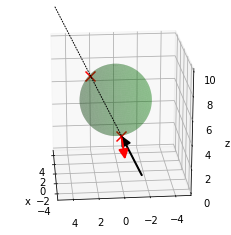

In [16]:
ax = plt.figure().add_subplot(projection='3d')
ax.view_init(elev=20, azim=175, roll=0)
ax.axes.set_xlim3d(left=-5, right=5) 
ax.axes.set_ylim3d(bottom=-5, top=5) 
ax.axes.set_zlim3d(bottom=0, top=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt_sphere(sc,s2_r)
ax.scatter(is1a[0],is1a[1],is1a[2], c='r', marker='x', s=100) 
ax.scatter(is2a[0],is2a[1],is2a[2], c='r', marker='x', s=100) 
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0, linewidth=2)
a = Arrow3D([r2o[0], is1a[0]], [r2o[1], is1a[1]], [r2o[2], is1a[2]], **arrow_prop_dict)
ax.add_artist(a)
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0, linewidth=1, linestyle=':')
b = Arrow3D([r2o[0], end2[0]], [r2o[1], end2[1]], [r2o[2], end2[2]], **arrow_prop_dict)
ax.add_artist(b)
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='r', shrinkA=0, shrinkB=0, linewidth=2)
c = Arrow3D([is1a[0], is1a[0]+2.0*nhat[0]], [is1a[1], is1a[1]+2.0*nhat[1]], [is1a[2], is1a[2]+2.0*nhat[2]], **arrow_prop_dict)
ax.add_artist(c)
plt.gca().set_aspect('equal')
plt.show() 

This 3D image illustrates the ray intersecting the sphere. 

The intersection locations that we calculated earlier are shown as red crosses, and match the locations that the ray would encounter if it passes the sphere and continues beyond the range of the plot.

The normal that we calculated is shown as a red arrow, and also behaves as we would expect (pointing directly away from the sphere surface at the chosen location).

We can repeat the same process for any object which is fully described by a mathematical equation. Commmon examples include cones and paraboloids. Some of these objects can be difficult to visualise.


## Lecture Example 3: General object
**Find the unit normal at the point where the ray from $(-1,2,0)$ to $(3,1,4)$ cuts the hyperbolic paraboloid $x^2-y^2+4z=0$.**

In [17]:
r3_o = sym.Matrix([[-1, 2, 0]])
r3_e = sym.Matrix([[3, 1, 4]])
ray3 = r3_o + t * (r3_e - r3_o)
hp = x**2 - y**2 + 4 * z
print(hp)

x**2 - y**2 + 4*z


In [18]:
sols = sym.solve(hp.subs([(x, ray3[0]), (y, ray3[1]), (z, ray3[2])]),t)
valid_sols = [i for i in sols if i <= 1]
valid_sols.sort()
for i, val in enumerate(valid_sols) :
    print("intersection {} found at t={}".format(i+1,val.evalf()))

intersection 1 found at t=0.200000000000000


In [19]:
is3  = (ray3.subs(t,valid_sols[0].evalf()))
r3o  = np.array(r3_o.tolist()[0],dtype='float64')
is3a = np.array(is3.tolist()[0],dtype='float64')
print("intersection occurs at ({:0.3f},{:0.3f},{:0.3f})".format(is3a[0],is3a[1],is3a[2]))

intersection occurs at (-0.200,1.800,0.800)


Thanks to python, we've identified where the intersections between this ray and the hyperbolic paraboloid occur. However, that doesn't answer the question, which wants to know the unit normal at that point.

To that end, we'll use the function which returns a vector $\bf\vec{\nabla{\phi}}$, evaluated at the location where we found the intersection to calculate the specific normal we need:

In [20]:
gradhp = grad(hp)
nx = float(gradhp[0].subs({x:is3a[0], y:is3a[1], z:is3a[2]}))
ny = float(gradhp[1].subs({x:is3a[0], y:is3a[1], z:is3a[2]}))
nz = float(gradhp[2].subs({x:is3a[0], y:is3a[1], z:is3a[2]}))
n = [nx,ny,nz]
n = n/np.linalg.norm(n)
print("unit normal=", n)

unit normal= [-0.07412493 -0.66712438  0.74124932]


We've answered the question, and obtained the same solution that we recovered mathematically in the lectures.

The final stage is to see if the solutions make sense visually. With mathematical surfaces given as a scalar function, we often have to create a grid of $x$ and $y$ values, before rearranging the scalar function to create a grid of $z$ values:

Text(0.5, 0, 'z')

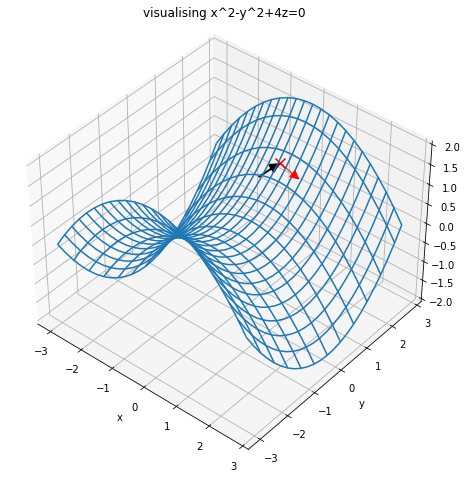

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,8))
ax.view_init(elev=40, azim=-50, roll=0)
X = np.arange(-3, 3, 0.25)
Y = np.arange(-3, 3, 0.25)
X, Y = np.meshgrid(X, Y)
#rearranging the expression to make z the subject:
Z = (X*X-Y*Y)/(-4)
#surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.3)
surf = ax.plot_wireframe(X, Y, Z, rstride=2, cstride=1, label='parabolic bowl')
ax.scatter(is3a[0],is3a[1],is3a[2], c='r', marker='x', s=100) 
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0, linewidth=2)
a = Arrow3D([r3o[0], is3a[0]], [r3o[1], is3a[1]], [r3o[2], is3a[2]], **arrow_prop_dict)
ax.add_artist(a)
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='r', shrinkA=0, shrinkB=0, linewidth=1)
b = Arrow3D([is3a[0], is3a[0]-n[0]], [is3a[1], is3a[1]-n[1]], [is3a[2], is3a[2]-n[2]], **arrow_prop_dict)
ax.add_artist(b)
ax.set_zlim(-2, 2)
ax.title.set_text('visualising x^2-y^2+4z=0')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

Some points to note from this diagram: the ray does appear to intersect the surface at the location we found using maths. The normal at this location does appear to point away from surface. You can double check this by varying the viewing angle of the plot.

This function looks like a saddle point: we encountered saddle points when looking at Partial Derivatives. 

Maybe, using your maths skills, you could check whether this is a true saddle point, **using the second derivative test**?

## Over to you
Try some more examples from the lectures or the tutorial questions once you are satisfied with the mathematics.